In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [ ]:
# looks wierd but makes pixel values btw -1 and +1
# assume they are transformed from (0, 1)
# min value = (0 - 0.5) / 0.5 = -1
# max value = (1 - 0.5) / 0.5 = +1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
len(train_dataset)

60000

In [ ]:
from torch.utils.data import dataset
batch_size = 128
data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    # nn.Sigmoid()
)

In [ ]:
# Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
D = D.to(device)
G = G.to(device)

cuda:0


In [ ]:
# scale image back to (0, 1)
def scale_image(img):
  out = (img + 1) / 2
  return out

In [ ]:
# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# create a folder to store generated images
if not os.path.exists('GAN_images'):
  os.makedirs('GAN_images')

In [12]:
from torch.optim import optimizer
# Training loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.ones(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(200):
  for inputs, _ in data_loader:
    # don't need targets
    # reshape and move to GPU
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)
    # set ones and zeros to correct size
    ones = ones_[:n]
    zeros = zeros_[:n]

    # Train discriminator
    
    # real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    # gradient descent step
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # Train generator

    # do it twice
    for _ in range(2):
      # fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      # reverse the labels
      g_loss = criterion(fake_outputs, ones)

      # gradient descent step
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    # save losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  ## print and save
  print(f"Epoch {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

  # PyTorch has a function to save a bunch of images to file
  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_image(fake_images), f"GAN_images/{epoch+1}.png")


Epoch 0, d_loss: 1.6781454178271815e-05, g_loss: 2.6562101993476972e-05
Epoch 1, d_loss: 4.4194139263709076e-06, g_loss: 7.428169737977441e-06
Epoch 2, d_loss: 1.7328765125057544e-06, g_loss: 3.2062250738817966e-06
Epoch 3, d_loss: 9.598820724932011e-07, g_loss: 1.4019494756212225e-06
Epoch 4, d_loss: 4.4889731043440406e-07, g_loss: 8.953108476816851e-07
Epoch 5, d_loss: 3.241001422793488e-07, g_loss: 5.948044190517976e-07
Epoch 6, d_loss: 1.8626448650138627e-07, g_loss: 3.9984769273360143e-07
Epoch 7, d_loss: 1.62670971803891e-07, g_loss: 2.1855032628081972e-07
Epoch 8, d_loss: 8.878608070972405e-08, g_loss: 1.5273688802608376e-07
Epoch 9, d_loss: 6.45716937697216e-08, g_loss: 1.0430811414607888e-07
Epoch 10, d_loss: 7.450578465295621e-08, g_loss: 8.940696005765858e-08
Epoch 11, d_loss: 2.91814394870471e-08, g_loss: 5.587935092421503e-08
Epoch 12, d_loss: 2.607703031287656e-08, g_loss: 7.450580152834618e-09
Epoch 13, d_loss: 9.313224857976365e-09, g_loss: 3.725290076417309e-09
Epoch 1

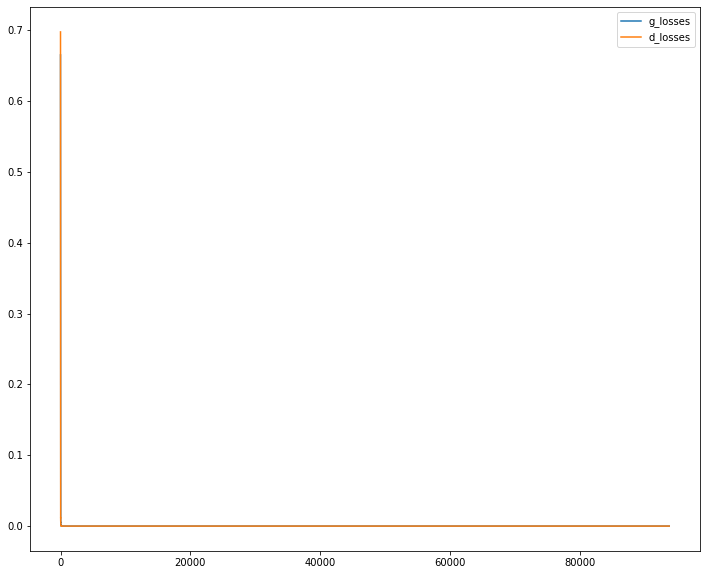

In [13]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,10))
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()
plt.show()

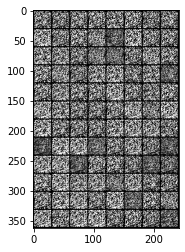

In [14]:
from skimage.io import imread
a = imread('GAN_images/1.png')
plt.imshow(a)

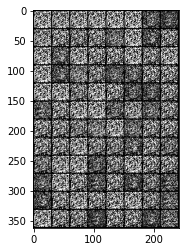

In [15]:
a = imread('GAN_images/50.png')
plt.imshow(a)

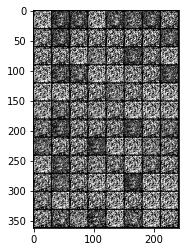

In [16]:
a = imread('GAN_images/100.png')
plt.imshow(a)

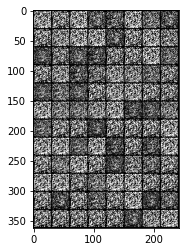

In [17]:
a = imread('GAN_images/150.png')
plt.imshow(a)

In [ ]:
a = imread('GAN_images/200.png')
plt.imshow(a)